In [1]:
# This is one quick way to create a simple flat lensed sky simulation library for a 'CMB-S4' experimental configuration, with homogeneous noise maps.
# The first parameter is the experimental label, and the second parameter (LDres) fixes the pixel size of the data.
# These and other pure convenience functions are in the __init__.py of lensit, see corresponding routines for precise definitions.
# Libraries for different configuration labels created with consistent sky resolution and 'nsims' will share the same lensed CMB skies.
# Libraries for different configuration labels created with consistent data resolution and 'nsims' will share the same noise phases.
# On the first call,if not present on disk all phases will be generated and stored in sqlite3 databases with the provided random number generator.
# A bunch of things will be cached in ./temp folder, that will be done only once.
import lensit as li
sims = li.get_maps_lib('S4',11,HDres=11,cache_lenalms=False,cache_maps=False,nsims = 10)

pbs.py : This looks like invocation on the laptop
pbs.py : setup OK, rank 0 in 1
ell_mat:caching ells in  ./temp/ellmats/ellmat_11_11/ellmat.npy
++ ffs_alm_pyFFTW :: building and caching FFTW wisdom, this might take a little while...
 [00:00:02] Generating CMB phases ---------> 90%
I see 4 fields: p t e b
 pb tb eb set to zero
 [00:00:04] Generating Noise phases ---------> 90%


rank 0, ffs_deflect::buffers size, chk_shape (51, 43) [2048 2048]
ell_mat:caching e2iphi in  ./temp/ellmats/ellmat_11_11/e2iphimat.npy
rank 0, ffs_deflect::buffers size, chk_shape (51, 43) [2048 2048]


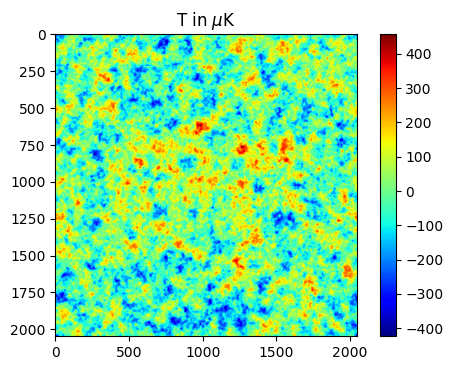

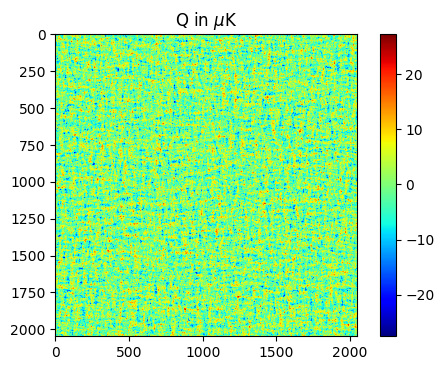

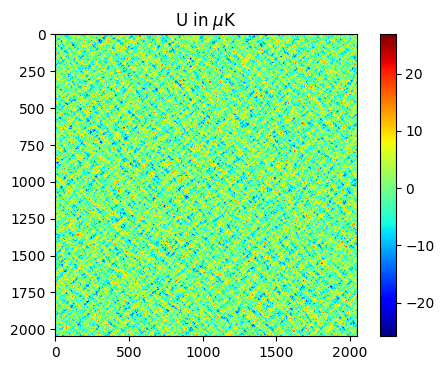

In [2]:
# Calling and showing maps:
%matplotlib inline
T = sims.get_sim_tmap(0)
Q,U = sims.get_sim_qumap(0)
for _map,lab in zip([T,Q,U],['T','Q','U']):  
    pl.figure()
    pl.imshow(_map,cmap = 'jet')
    pl.colorbar()
    pl.title(lab + r' in $\mu $K')

Unlensed skies :
 I am using pyFFTW on 4 threads to perform ffts.
 I keep track of multipoles up to 6000, on a rectangle with sides 25.4 by 25.4 degrees, using 2048 x 2048 points.
 fsky : 0.016


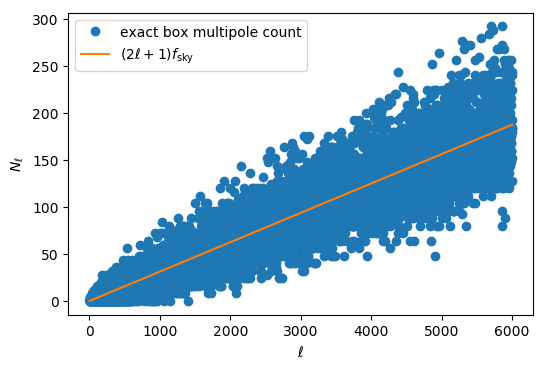

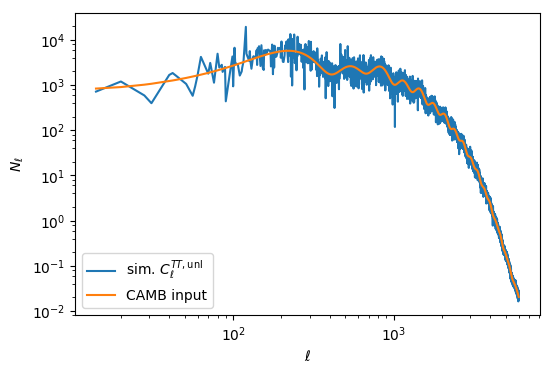

In [3]:
# The multipole structure on the flat sky is handled by a ffs_alm instance, see ffs_cov/ell_mat.py.
# The ones provided there are all fairly non-sophisticated.
# The instance handling the unlensed CMB are these ones:
lib_unlsky = sims.lencmbs.unlcmbs.lib_skyalm

print "Unlensed skies :"
print " I am using pyFFTW on %s threads to perform ffts."%lib_unlsky.threads
print " I keep track of multipoles up to %s, on a rectangle with sides %.1f by %.1f degrees, using %s x %s points."%(lib_unlsky.ellmax,lib_unlsky.lsides[0] / np.pi * 180.,lib_unlsky.lsides[1] / np.pi * 180., lib_unlsky.shape[0],lib_unlsky.shape[1])
print " fsky : %.3f"%(np.prod(lib_unlsky.lsides)/4./np.pi)

# The mode structure is more complicated than on the curved sky:
pl.plot(np.arange(lib_unlsky.ellmax + 1),lib_unlsky.get_Nell()[:lib_unlsky.ellmax+1],'o',label = 'exact box multipole count')
pl.plot( (2 * np.arange(lib_unlsky.ellmax+1) + 1) * np.prod(lib_unlsky.lsides) / (4. * np.pi),label = r'$(2\ell + 1)f_{\rm sky}$')
pl.xlabel('$\ell$');pl.ylabel(r'$N_\ell$');leg = pl.legend()

# Here is how to calculate simple spectra :
cltt_unl = lib_unlsky.alm2cl(sims.lencmbs.unlcmbs.get_sim_tlm(0))
ell = np.where(cltt_unl > 0.)[0]
pl.figure()
pl.plot(ell,cltt_unl[ell] * ell * (ell+ 1.) /2./np.pi,label = r'sim. $C_\ell^{TT,\rm unl}$')

# and compare to fiducial cosmo:
clunl,cllen = li.get_fidcls(ellmax_sky= np.max(ell))
pl.loglog(ell,clunl['tt'][ell]* ell * (ell+ 1.) /2./np.pi,label = 'CAMB input')
pl.xlabel('$\ell$');pl.ylabel(r'$N_\ell$');leg = pl.legend()

ell_mat:caching ells in  ./temp/ellmats/ellmat_14_14/ellmat.npy
++ ffs_alm_pyFFTW :: building and caching FFTW wisdom, this might take a little while...
 [00:00:18] Generating CMB phases > 00%
I see 4 fields: p t e b
 pb tb eb set to zero
Lensed skies :
 I am using pyFFTW on 4 threads to perform ffts.
 I keep track of multipoles up to 6000, on a rectangle with sides 203.1 by 203.1 degrees, using 16384 x 16384 points.
 fsky : 1.000
rank 0, ffs_deflect::buffers size, chk_shape (76, 76) [2200 2200]
ell_mat:caching e2iphi in  ./temp/ellmats/ellmat_14_14/e2iphimat.npy
rank 0, ffs_deflect::buffers size, chk_shape (76, 76) [2200 2200]


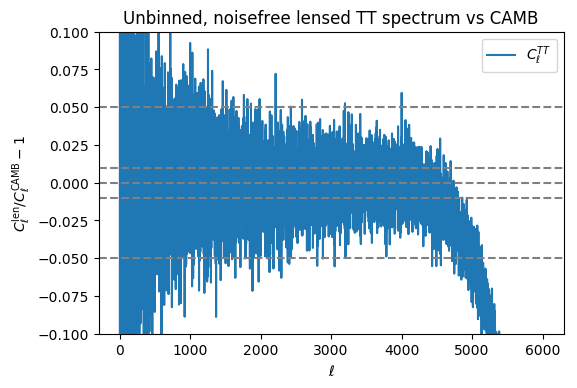

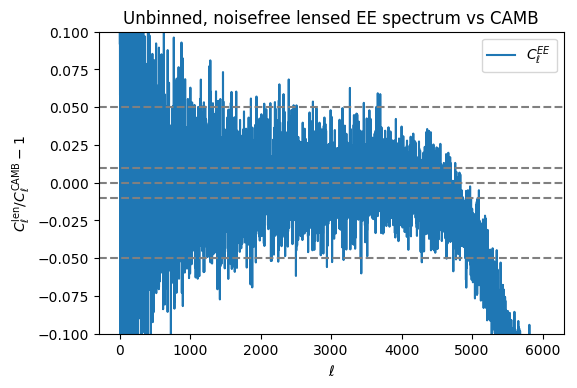

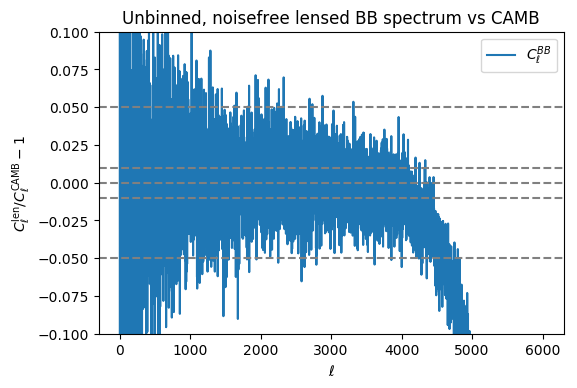

In [4]:
# Testing now flat sky lensed spectra with default parameters against CAMB on a full sky sized box.
# Calling lensed CMB library:
lencmbs = li.get_lencmbs_lib(res = 14,nsims = 1,cache_sims=True)
lib_lensky = lencmbs.lib_skyalm

print "Lensed skies :"
print " I am using pyFFTW on %s threads to perform ffts."%lib_lensky.threads
print " I keep track of multipoles up to %s, on a rectangle with sides %.1f by %.1f degrees, using %s x %s points."%(lib_lensky.ellmax,lib_lensky.lsides[0] / np.pi * 180.,lib_lensky.lsides[1] / np.pi * 180., lib_lensky.shape[0],lib_lensky.shape[1])
print " fsky : %.3f"%(np.prod(lib_lensky.lsides)/4./np.pi)

# It might take about 30 to 45 seconds with default parameters to lens each one of the T Q U full sized maps of 16384 ** 2 points.
fidunl,predlen = li.get_fidcls(ellmax_sky=lib_lensky.ellmax)
for field in ['t','e','b']:
    pl.figure()
    clsim_len = lib_lensky.alm2cl(lencmbs.get_sim_alm(0,field))
    ell = np.where( (clsim_len > 0.) & (np.arange(len(clsim_len)) > 1))[0]
    pl.plot(ell,clsim_len[ell]/ predlen[field + field][ell]-1.,label = '$C_\ell^{%s}$'%(field + field).upper())
    pl.xlabel('$\ell$');pl.ylabel(r'$C_\ell^{\rm len} / C_\ell^{\rm CAMB} -1$')
    leg = pl.legend();
    pl.ylim(-0.1,0.1)
    pl.title('Unbinned, noisefree lensed %s spectrum vs CAMB'%(field + field).upper())
    for val in [0.,0.01,0.05,-0.01,-0.05] : pl.axhline(val,color = 'grey',linestyle = '--')